# Clean FoodEx data and Production data
Check the FoodEx classificaiton data and filter it to keep only food products
- **1. Keep only food products:** We are ignoring other livestock and crop derived products that are not food. This was done through manual labeling, in the ``Trade_ItemCodes_Isfood_foodex_REVISED.csv`` file. 
- **2. Filter production data:** Keep only the products in trade for which we also have production data. Also check the yearly data availability, we will only keep products with complete coverage for all the years studied. 
- **3. Fix GDP data:** Clean GDP data.
- **4. Keep only countries common in trade,production and GDP.**

This returns the final data that we will use for the whole analysis. 

In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd #pip installed
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt 
import ast
import seaborn as sns
import openpyxl
from tqdm import tqdm
from matplotlib.lines import Line2D 
from scipy.interpolate import interp1d

In [2]:
# FUNCTION DEFINITION

def Clean_item_names(data, item_list,foodex_levels):
    """Clean `item` names from 'data' to match 'item_list'.

    The function cleans special characters in item names and matches the items between 'data' and 'item_list'
    to guarantee the consistancy between both dataframes. 

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing an 'item' column to be cleaned and filtered.
    - item_list (pd.DataFrame): DataFrame containing the metadata file for each item.

    Returns:
    Tuple: A tuple containing two DataFrames:
        1. Cleaned and filtered DataFrame 'data' with item names matched to the 'item_list'.
        2. Original 'item_list' DataFrame with cleaned item names.

    Example:
    >>> cleaned_data, cleaned_item_list = Clean_item_names(input_data, valid_items)
    """
    
    # Clean item names
    replacements = {'�': 'é', ';': ',', '"': ''}

    item_list['item']=item_list.item.replace(replacements,regex=True)

    data['item']=data.item.replace(replacements,regex=True)


    data.replace({'MatÃ© leaves':'Maté leaves',
                   'Extracts, essences and concentrates of tea or mate, and preparations with a basis thereof or with a basis of tea or matÃ©':
                   'Extracts, essences and concentrates of tea or mate, and preparations with a basis thereof or with a basis of tea or maté'},inplace=True)

    # Add Foodex labels to item_list 
    item_list= pd.merge(item_list, foodex_levels,left_on='L1_foodex',right_on='Code',how='left').drop(columns='Code').rename(columns={'IndentedTree':'Food_group'})

    # Merge itemlist & data:
    data= pd.merge(data, item_list.loc[:,['item','Is_food','L1_foodex','Food_group']],on='item',how='left',copy=False)
    print(data)
    return data, item_list


def fill_na_spline_fit(df, order=1):

    # Create interpolator with linear extrapolation
    years_nan = df['Year'].loc[df['Value'].isna()].unique()
    df_nan = df.copy(deep=True)
    df_nan.loc[df_nan.Year.isin(years_nan),'Year'] =np.nan

    # Get index positions and values that are not NaN

    f = interp1d(df_nan['Year'].dropna(), df_nan['Value'].dropna(), kind='linear', fill_value='extrapolate')
    extrap_values = f(years_nan)

    df.loc[df['Year'].isin(years_nan),'Value'] = extrap_values
    #df['Value'] = df['Value'].interpolate(method='spline',order =order,limit_direction='both',) #order =1,
    return df



def Prep_GDP_Data(GDP, trade, prod,unique_ISO,save_figs=False):
    '''
    Prepares GDP data for the analysis.
    GDP data is filtered to the years of interest and countries with trade and production data.
    Missing GDP data is fixed by interpolating the data.
    '''
    # Load iso codes
    countries_FAOSTAT = pd.read_csv('../Data/input_2023/FAOSTAT_list_countries_ISO.csv',na_filter=False)
    #save end year BELUX
    end_F15 = int(countries_FAOSTAT.loc[countries_FAOSTAT['ISO3 Code']=='F15','End Year'].values[0])
    countries_FAOSTAT=countries_FAOSTAT.loc[:,['Country','ISO3 Code']]
    mapping = countries_FAOSTAT.set_index("ISO3 Code")["Country"].to_dict()


    GDP_iso = pd.merge(GDP,countries_FAOSTAT, right_on='Country', left_on='Area',how='right')
    GDP_iso.drop(columns=['Country','Element','Unit'],inplace=True)

    # Filter GDP in year range:
    GDP_iso = GDP_iso.loc[(GDP_iso.Year>=1986) & (GDP_iso.Year<=2022),:]
    GDP_iso=GDP_iso.loc[GDP_iso['ISO3 Code'].isin(unique_ISO),:]
    GDP_iso = GDP_iso.rename(columns={'ISO3 Code':'ISO'})

    # Check country-years for which we have GDP data available 
    list_gdp= GDP_iso.groupby(by='ISO',as_index=False).apply(lambda x: len(x),include_groups=False)
    list_gdp.rename(columns={None:'count'},inplace=True)
    list_gdp.sort_values(by='count',ascending=True)

    # Check country-years available in trade and prod data: 
    country_year_pairs = trade.groupby(by=['origin_country_ISO','year'],as_index=False).value.count().rename(columns={'origin_country_ISO':'country'})
    country_year_pairs_destin = trade.groupby(by=['destin_country_ISO','year'],as_index=False).value.count().rename(columns={'destin_country_ISO':'country'})
    country_year_pairs_prod = prod.groupby(by=['ISO3 Code','year'],as_index=False).value.count().rename(columns={'ISO3 Code':'country'})

    country_year_pairs=pd.concat([country_year_pairs,country_year_pairs_destin,country_year_pairs_prod])
    country_year_pairs.drop(columns=['value'],inplace=True)
    country_year_pairs.drop_duplicates(inplace=True)

    available_pairs=country_year_pairs.groupby(by='country',as_index=False).count().sort_values(by='year',ascending=True)
    
    # Compare available data: 
    compare_available_data= pd.merge(available_pairs,list_gdp, left_on='country',right_on='ISO',how='outer')
    
    excluded_countries= compare_available_data.loc[compare_available_data.ISO.isna(),:]
    compare_available_data= compare_available_data.loc[~compare_available_data.ISO.isna(),:]
    to_fix=compare_available_data.loc[compare_available_data['year']>compare_available_data['count'],:]
    print('Countries with missing GDP data:')
    print(to_fix)

    fig, ax = plt.subplots(2,int(np.ceil(len(to_fix)//2)+1), figsize=(10, 6))
    ax = ax.flatten()  # Make it easier to index

    # Fix missing data:
    for i,country_to_fix in tqdm(enumerate(to_fix.ISO)):
        GDP_fix= GDP_iso.loc[GDP_iso.ISO==country_to_fix,:]
        GDP_fix.sort_values(by='Year',ascending=True)
        # Add rows for years missing
        trade_filt = trade.loc[(trade.origin_country_ISO==country_to_fix) | (trade.destin_country_ISO==country_to_fix),:]
        complete_year_list=pd.Series(sorted(trade_filt.year.unique()),name='Year')
        complete_year_list

        #
        merged_GDP =pd.merge(GDP_fix,complete_year_list,how='outer',on='Year')

        merged_GDP=fill_na_spline_fit(merged_GDP,order=1)

        if save_figs == True:

            ax[i].plot(merged_GDP.Year.astype(int),merged_GDP.Value, color='tab:blue',zorder=1)
            if country_to_fix != 'F228':
                ax[i].plot(merged_GDP.Year[merged_GDP.Area.isna()],merged_GDP.Value[merged_GDP.Area.isna()],color='red',zorder=3)
            ax[i].scatter(merged_GDP.Year[merged_GDP.Area.isna()],merged_GDP.Value[merged_GDP.Area.isna()],color='red',zorder=3)
            ax[i].set_title(mapping[country_to_fix] + ' ('+country_to_fix+')')
            ax[i].set_xlim(int(min(merged_GDP.Year))-0.5,int(max(merged_GDP.Year))+0.5)
            ax[i].set_xticks(np.linspace(int(min(merged_GDP.Year)), int(max(merged_GDP.Year)), 3).astype(int))

            ax[7].set_visible(False)
            ax[0].set_ylabel('GDP (million USD)')
            ax[4].set_ylabel('GDP (million USD)')

        # fill other columns
        merged_GDP['Area'] = merged_GDP['Area'].fillna(merged_GDP.Area[~merged_GDP.Area.isna()].unique()[0])
        merged_GDP['ISO']= merged_GDP['ISO'].fillna(merged_GDP.ISO[~merged_GDP.ISO.isna()].unique()[0])
        merged_GDP['Area Code'] = merged_GDP['Area Code'].fillna(merged_GDP['Area Code'][~merged_GDP['Area Code'].isna()].unique()[0])

        # correct gdp_iso
        GDP_iso = GDP_iso.loc[GDP_iso.ISO!=country_to_fix,:]
        GDP_iso = pd.concat([GDP_iso,merged_GDP],ignore_index=True)

    # Merge GDP_iso lux and belgium for the years in which it is BE-LUX (F15):
    merged_BELUX= pd.merge(GDP_iso.loc[(GDP_iso.ISO=='BEL')& (GDP_iso.Year<=end_F15),['Year','Value']],GDP_iso.loc[(GDP_iso.ISO=='LUX')& (GDP_iso.Year<=end_F15),['Year','Value']],on= 'Year',how='outer',suffixes=('_BEL','_LUX'))
    merged_BELUX['Value'] = merged_BELUX['Value_BEL'] + merged_BELUX['Value_LUX']
    merged_BELUX.drop(columns=['Value_BEL','Value_LUX'],inplace=True)
    merged_BELUX[['Area','ISO','Area Code']] = ['Belgium-Luxembourg','F15',np.nan]
    merged_BELUX[['Area','Area Code','Year','Value','ISO']]

    # Remove BEL and LUX from gdp_iso
    GDP_iso = GDP_iso.loc[~((GDP_iso.ISO.isin(['BEL','LUX'])) & (GDP_iso.Year<=end_F15)),:]
    GDP_iso = pd.concat([GDP_iso,merged_BELUX],ignore_index=True)
    # drop F15 from excluded_countries
    excluded_countries = excluded_countries.loc[excluded_countries.country!='F15',:]

    if save_figs == True:
        fig.tight_layout()
        fig.suptitle('Imputation for countries with missing GDP data', fontsize=16,y=1.05)
        legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=2, label='GDP time series'),
        Line2D([0], [0], color='red', lw=2, label='Imputed GDP data')
        ]
        fig.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2), ncol=1, frameon=False)
        fig.savefig(f'../Plots/2023/GDP_missing_data.pdf', bbox_inches='tight')

    return GDP_iso, excluded_countries


## 1. Foodex cleaning
Keep only food products, not other byproducts (non-human consumption). 

In [3]:
# Trade data

data_trade = pd.read_csv('../Data/intermediate/Trade_fixed_geo.csv', encoding='utf-8')


In [5]:

country_metadata = pd.read_csv('../Data/intermediate/Country_info_metadata.csv', encoding='utf-8')

# Load Foodex Data
item_list =pd.read_csv('../Data/input_2023/Trade_ItemCodes_Isfood_foodex_REVISED.csv', sep=',', encoding='utf-8').rename(columns={'Item':'item'}) 
foodex_levels =pd.read_excel('../Data/input_2023/Foodex_raw/Exposure_Hierarchy_revision2.xlsx').loc[:,['Code','IndentedTree']]

data_trade, item_list = Clean_item_names(data_trade, item_list, foodex_levels)

# Filter food items only: 
data_trade = data_trade.loc[data_trade['Is_food']>0,:].drop(columns=['Is_food'])

print('Unique food products in data_trade after filtering, '+ str(len(data_trade.item.unique())))

# Filter items in foodex 
food_item_list = item_list.loc[item_list.item.isin(data_trade.item.unique()),:]

print('Unique food products in food_item_list after filtering, '+ str(len(food_item_list.item.unique())))


# Match items
print('Items in data, missing in item list: ',set(data_trade.item.unique()).difference(set(item_list.item.unique()))) 
print('Items in item_list, not in data: ',set(item_list.item.unique()).difference(set(data_trade.item.unique()))) #

# Save Food_item_list
food_item_list.to_csv('../Data/intermediate/Food_item_list_with_FoodEx.csv', index=False)

                        item  item_code  year      unit    value  \
0         Cake, oilseeds nes        341  2017         t   463.11   
1         Cake, oilseeds nes        341  2019         t  1192.62   
2           Almonds, shelled        231  2005         t     3.00   
3         Cake, oilseeds nes        341  2017  1000 USD    85.00   
4           Almonds, shelled        231  2005  1000 USD     3.00   
...                      ...        ...   ...       ...      ...   
35528991                Wine        564  1988  1000 USD     1.00   
35528992                Wine        564  1992  1000 USD     8.00   
35528993                Wine        564  1999  1000 USD     2.00   
35528994                Wine        564  2004  1000 USD     2.00   
35528995                Wine        564  2020  1000 USD    14.00   

                        origin_country destin_country origin_country_ISO  \
0                            Argentina    Afghanistan                ARG   
1                            Ar

## 2. Clean production data

In [6]:
# Production data Load  
data_prod= pd.read_csv('../Data/input_2023/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_All_Data_(Normalized).csv', sep=',',low_memory=False, encoding='utf-8',index_col=0).reset_index()
data_prod.columns = data_prod.columns.str.lower().str.replace(' ', '_')

# Rename wrong formatted country names
data_prod.rename({'TÃ¼rkiye':'Türkiye',"CÃ´te d'Ivoire":"Côte d'Ivoire",'RÃ©union':'Réunion'}, inplace=True)

# Remove production aggregates
not_countries= ['Least Developed Countries (LDCs)', 'Small Island Developing States (SIDS)', 'Net Food Importing Developing Countries (NFIDCs)', 'Land Locked Developing Countries (LLDCs)', 'Low Income Food Deficit Countries (LIFDCs)']
data_prod= data_prod.loc[~data_prod.area.isin(not_countries),:]

In [7]:
# Get list of all countries in trade data
all_countries = set(data_trade.origin_country).union(data_trade.destin_country)

# Load data from FAOSTAT to merge 
countries_FAOSTAT=pd.read_csv('../Data/input_2023/FAOSTAT_list_countries_ISO.csv',encoding='utf-8',sep=',')
countries_FAOSTAT=countries_FAOSTAT.loc[:,['Country','ISO3 Code']]

# Check countries with name mismatch in production data
no_overlap = list(set(data_prod.area).difference(set(countries_FAOSTAT['Country'].unique())))
print('Countries with a name mismatch:',no_overlap)


Countries with a name mismatch: []


In [8]:
# Add ISO3 codes to production data
data_prod = data_prod.merge(countries_FAOSTAT, how='left', left_on='area', right_on='Country')
data_prod.drop(columns=['Country'],inplace=True)
data_prod

# Filter years of interest (only those in data_trade)
year_start = 1986
year_end= 2023
data_prod = data_prod.loc[(data_prod.year>=year_start) & (data_prod.year<=year_end),:]
print(len(data_prod.area.unique()))

# Remove countries not in trade data 
data_prod_countries = data_prod.loc[(data_prod.area.isin(all_countries)),:]
print(len(data_prod_countries.area.unique()))

no_overlap= list(set(all_countries).difference(set(data_prod_countries.area)))
print('Countries in production data not in trade data:',no_overlap)

240
210
Countries in production data not in trade data: ['South Georgia and the South Sandwich Islands', 'Wake Island', 'United States Minor Outlying Islands', 'Johnston Island', 'Svalbard and Jan Mayen Islands', 'Midway Island', 'Heard and McDonald Islands', 'Bouvet Island', 'Monaco']


In [9]:
# Check items 
print('Num of "item_codes" in data_prod:',len(data_prod_countries.item_code.unique()))
print('Num of "item_code" in data_trade:',len(data_trade.item_code.unique()))

# Check overlapping items
print('Food products in data_prod AND in data_trade:',len(set(data_prod_countries.item_code.unique()).intersection(data_trade.item_code.unique())))
print('Food products in data_prod AND in data_trade:',len(set(data_prod_countries.item.unique()).intersection(data_trade.item.unique())))

# Non intersected items
not_intersected = set(data_trade.item).difference(data_prod_countries.item.unique())
print('Food products in data_trade not in data_prod:',len(not_intersected))

not_intersected


Num of "item_codes" in data_prod: 302
Num of "item_code" in data_trade: 431
Food products in data_prod AND in data_trade: 234
Food products in data_prod AND in data_trade: 234
Food products in data_trade not in data_prod: 197


{'Almonds, shelled',
 'Animal oils and fats n.e.c.',
 'Animal or vegetable fats and oils and their fractions, chemically modified, except those hydrogenated, inter-esterified, re-esterified or elaidinized, inedible mixtures or preparations of animal or vegetable fats or oils',
 'Apple juice',
 'Apple juice, concentrated',
 'Apricots, dried',
 'Barley flour and grits',
 'Barley, pearled',
 'Beet pulp',
 'Bovine meat, salted, dried or smoked',
 'Bran of barley',
 'Bran of buckwheat',
 'Bran of cereals n.e.c.',
 'Bran of maize',
 'Bran of millet',
 'Bran of mixed grain',
 'Bran of oats',
 'Bran of pulses',
 'Bran of rice',
 'Bran of rye',
 'Bran of sorghum',
 'Bran of wheat',
 'Brazil nuts, shelled',
 'Bread',
 'Breakfast cereals',
 'Bulgur',
 'Butter of karite nuts',
 'Buttermilk, curdled and acidified milk',
 'Cane sugar, non-centrifugal',
 'Canned mushrooms',
 'Cashew nuts, shelled',
 'Cassava, dry',
 'Cattle, butcher fat',
 'Cereal preparations',
 'Chocolate products nes',
 'Cider and

In [10]:
# KEEP BASIC PRODUCTS: 
to_keep = set(data_prod_countries.item.unique()).intersection(data_trade.item.unique()) # keep products in 

data_prod_keep = data_prod_countries.loc[data_prod_countries.item.isin(to_keep),:]
data_trade_keep = data_trade.loc[(data_trade.item.isin(to_keep)),:] #& (data_trade.unit =='1000 US$')

# Keep only production column
data_prod_keep = data_prod_keep.loc[(data_prod_keep.element=='Production'),:].reset_index(drop=True)
data_prod_keep= data_prod_keep.drop(columns =['area_code_(m49)','item_code_(cpc)','element_code','year_code','flag','note'])

# Check temporal resolution of data: 
group_y= data_prod_keep.groupby(by='item_code').apply(lambda group : len(group.year.unique()))
print(group_y.value_counts()) # 216 products have complete temporal ressolution beteween 1986-2022

# Drop low temporal resolution products (for tonnes): "Rubber..." and "Butter goat milk are the very low resolution products"
to_drop = list(group_y[group_y<37].index)
data_prod_keep= data_prod_keep[~data_prod_keep.item_code.isin(to_drop)].reset_index(drop=True)  
data_trade_keep= data_trade_keep[data_trade_keep.item_code.isin(data_prod_keep.item_code.unique())].reset_index(drop=True)

# Keep only data until 2022
data_prod_keep = data_prod_keep.loc[data_prod_keep.year<=2022,:].reset_index(drop=True)
data_trade_keep = data_trade_keep.loc[data_trade_keep.year<=2022,:].reset_index(drop=True)

# Fill nans in production with 0s
data_prod_keep['value']=data_prod_keep['value'].fillna(0)

/tmp/ipykernel_1825388/2739400032.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_y= data_prod_keep.groupby(by='item_code').apply(lambda group : len(group.year.unique()))


38    172
37     43
5       1
7       1
Name: count, dtype: int64


Countries with missing GDP data:
    country  year   ISO  count
58     F206    26  F206   22.0
59     F228     6  F228    5.0
60     F248     6  F248    4.0
61      F51     7   F51    4.0
62      F62     7   F62    4.0
195     TLS    37   TLS   33.0
215     YEM    37   YEM   34.0


7it [00:18,  2.63s/it]


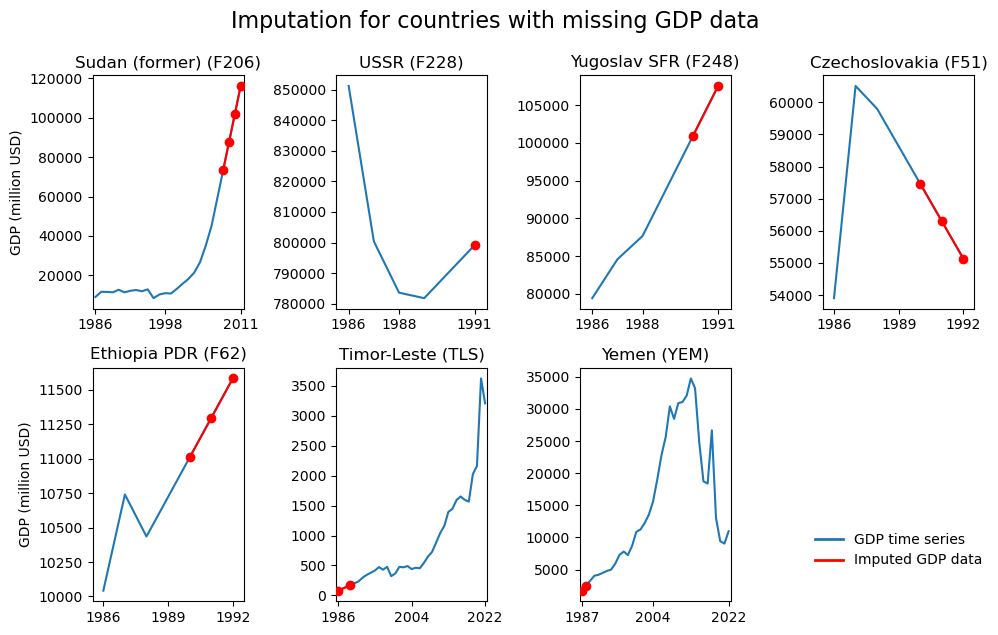

In [11]:
# Prepare GDP data:
GDP_og = pd.read_csv('../Data/input_2023/Macro-Statistics_Key_Indicators_E_All_Data/Macro-Statistics_Key_Indicators_E_All_Data.csv',sep=',')
GDP_og = GDP_og.loc[(GDP_og.Element == 'Value US$') &(GDP_og.Item=='Gross Domestic Product'),:]

# Reshape GDP data to long format
GDP = GDP_og.melt(
    id_vars=['Area','Area Code','Unit','Element'],
    value_vars=['Y'+str(year) for year in range(1986,2023)],
    var_name="Year", 
    value_name="Value"
)

GDP['Year'] = GDP['Year'].str.replace('Y','').astype(int)
GDP = GDP.loc[~GDP.Value.isna(),:]

unique_ISO = list(set(data_trade_keep.origin_country_ISO).union(set(data_trade_keep.destin_country_ISO)).union(set(data_prod_keep['ISO3 Code'].unique()))) 
GDP_iso, excluded_countries = Prep_GDP_Data(GDP, data_trade_keep, data_prod_keep,unique_ISO,save_figs= True)


# Filter trade and production data to keep only countries with GDP data
excluded_countries.to_csv('../Data/intermediate/Excluded_countries_because_no_GDP_data.csv', index=False)
pd.merge(excluded_countries, country_metadata.loc[:,['Country','ISO3 Code']], right_on='ISO3 Code', left_on='country', how='left').to_csv('../Data/intermediate/Excluded_countries_metadata_no_GDP_data.csv', index=False)

# Filter trade data
data_trade_keep = data_trade_keep.loc[~(data_trade_keep.origin_country_ISO.isin(excluded_countries.country)) & ~(data_trade_keep.destin_country_ISO.isin(excluded_countries.country)), :].reset_index(drop=True)
# Filter production data
data_prod_keep = data_prod_keep.loc[~(data_prod_keep['ISO3 Code'].isin(excluded_countries.country)), :].reset_index(drop=True)  


In [12]:
excluded_countries

,country,year,ISO,count
26,BVT,7,NaN,NaN
66,FRO,37,NaN,NaN
73,GLP,21,NaN,NaN
80,GUF,21,NaN,NaN
83,HMD,2,NaN,NaN
99,JTN,3,NaN,NaN
126,MID,4,NaN,NaN
135,MTQ,21,NaN,NaN
144,NIU,37,NaN,NaN
164,REU,21,NaN,NaN


In [ ]:
print('Num items final:',len(data_trade_keep.item.unique()))
print('Num items final:',len(data_prod_keep.item.unique()))

print('Num countries final, trade:',len(set(data_trade_keep.origin_country_ISO.unique()).union(set(data_trade_keep.destin_country_ISO.unique()))))
print('Num countries final prod:',len(data_prod_keep.area_code.unique()))

unique_ISO_final = list(set(data_trade_keep.origin_country_ISO).union(set(data_trade_keep.destin_country_ISO)).union(set(data_prod_keep['ISO3 Code'].unique())))

data_trade_keep.to_csv('../Data/intermediate/Data_trade_clean.csv', index=False)
data_prod_keep.to_csv('../Data/intermediate/Data_production_clean.csv', index=False)
GDP_iso.to_csv('../Data/intermediate/GDP_clean.csv', index=False)

Num items final: 215
Num items final: 215
Num countries final: 202
Num countries final: 201
